***What makes a smile? A Deep Neural Network Point of View***

# Dependencies

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os


# Downloading Data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ananthu017/emotion-detection-fer

 75% 49.0M/65.2M [00:02<00:00, 24.7MB/s]
100% 65.2M/65.2M [00:02<00:00, 30.4MB/s]


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jayeshrohansingh/emotion-detection-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 148M/151M [00:04<00:00, 46.8MB/s]
100% 151M/151M [00:04<00:00, 38.0MB/s]


In [ ]:
! unzip emotion-detection-dataset.zip

# How Data Looks

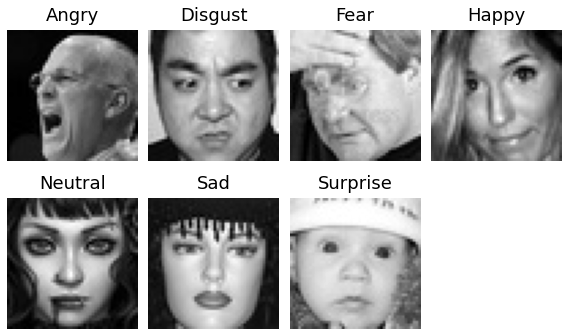

In [ ]:
dataset='/content/fer2013'
train_folder = os.path.join(dataset,"train")


images = []


for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(8, 5))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    #a,b,c=imgs.shape
    fig=plt.subplot(2, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.axis('off')
    plt.imshow(imgs,cmap = 'gray')
    
plt.tight_layout()

In [ ]:
data = pd.read_csv('/content/fer2013/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data Distribution

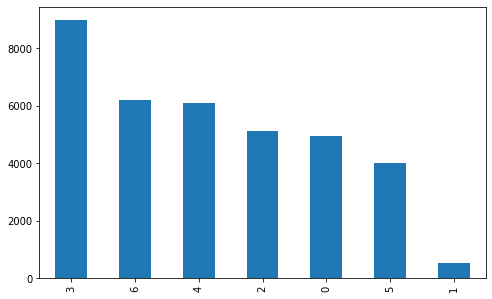

In [ ]:
data['emotion'].value_counts().plot(kind = 'bar',figsize = (8,5))

# Image Pipeline

In [ ]:
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,
                                   rotation_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path='/content/fer2013/train'
test_path = '/content/test'
val_path = '/content/fer2013/validation'


train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(48,48),
        color_mode='grayscale',
        batch_size=64,
        shuffle = True,
        seed = 42,
        class_mode = "categorical",
        classes = ['Angry','Fear','Happy','Neutral','Sad','Surprise'])

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(48,48),
        seed = 42,
        color_mode='grayscale',
        shuffle = False,
        batch_size=1,
        class_mode = "categorical",
        classes = ['angry','fearful','happy','neutral','sad','surprised'])

val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(48,48),
        seed = 42,
        color_mode='grayscale',
        shuffle = True,
        batch_size=64,
        class_mode = "categorical",
        classes = ['Angry','Fear','Happy','Neutral','Sad','Surprise'])

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


# After Proccessing

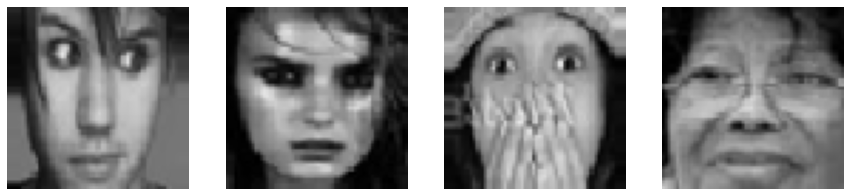

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_set)[0]

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [ ]:
class_map = train_set.class_indices
class_map

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}

# Model Building

# CNN 1

In [ ]:
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
cnn = tf.keras.models.Sequential()

################ 1st Layer ################
#Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(tf.keras.layers.Dropout(0.25))

################  2nd Layer ################
#Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
#Pooling
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(tf.keras.layers.Dropout(0.25))

################  3rd Layer ################
#Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
#Pooling
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(tf.keras.layers.Dropout(0.25))

################  4th Layer ################
#Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
#Pooling
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(tf.keras.layers.Dropout(0.25))

#Flattening
cnn.add(tf.keras.layers.Flatten())

#Full Connection

#Hidden Layers
cnn.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dropout(0.25))
#Output Layer
cnn.add(tf.keras.layers.Dense(units = 6, activation = 'softmax'))

cnn.summary()

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)      

In [ ]:
hist = cnn.fit(x = train_set, validation_data = val_set, epochs = 20)

Epoch 1/20
442/442 [==============================] - 23s 48ms/step - loss: 1.8800 - accuracy: 0.2610 - val_loss: 1.8854 - val_accuracy: 0.2606
Epoch 2/20
442/442 [==============================] - 21s 47ms/step - loss: 1.5657 - accuracy: 0.3804 - val_loss: 1.5131 - val_accuracy: 0.4001
Epoch 3/20
442/442 [==============================] - 23s 52ms/step - loss: 1.4285 - accuracy: 0.4389 - val_loss: 1.5245 - val_accuracy: 0.4315
Epoch 4/20
442/442 [==============================] - 21s 47ms/step - loss: 1.3451 - accuracy: 0.4721 - val_loss: 1.4740 - val_accuracy: 0.4358
Epoch 5/20
442/442 [==============================] - 21s 47ms/step - loss: 1.2940 - accuracy: 0.4957 - val_loss: 1.5906 - val_accuracy: 0.4123
Epoch 6/20
442/442 [==============================] - 21s 47ms/step - loss: 1.2629 - accuracy: 0.5087 - val_loss: 1.3596 - val_accuracy: 0.4785
Epoch 7/20
442/442 [==============================] - 21s 47ms/step - loss: 1.2291 - accuracy: 0.5219 - val_loss: 1.3924 - val_accuracy:

***Plot***

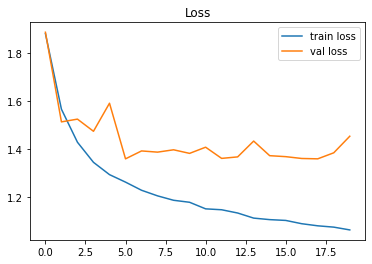

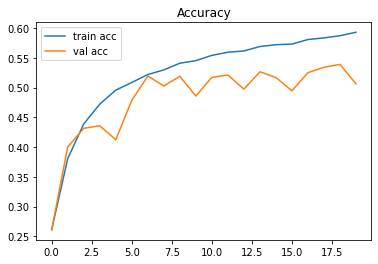

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

***Evaluation***

In [ ]:
cnn = cnn.evaluate(test_set)

111/111 [==============================] - 3s 22ms/step - loss: 1.1005 - accuracy: 0.5797


# CNN 2

In [ ]:
image_size = (48,48,1)

model = Sequential()
model.add(Conv2D(128,(3,3),activation = "relu", input_shape = image_size))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(148,(3,3),activation = "relu", input_shape = image_size))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D( 160, (3,3), activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D( 256, (3,3), activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D())


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation = "relu"))
model.add(Dense(6, activation = "softmax"))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization_11 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 46, 46, 128)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 148)       170644    
                                                                 
 batch_normalization_12 (Bat  (None, 44, 44, 148)      592       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 22, 22, 148)    

In [ ]:
history = model.fit(train_set,epochs=25,validation_data=val_set)

Epoch 1/25
442/442 [==============================] - 33s 70ms/step - loss: 1.7598 - accuracy: 0.3231 - val_loss: 2.6304 - val_accuracy: 0.1808
Epoch 2/25
442/442 [==============================] - 29s 65ms/step - loss: 1.5630 - accuracy: 0.3869 - val_loss: 1.6213 - val_accuracy: 0.3846
Epoch 3/25
442/442 [==============================] - 31s 69ms/step - loss: 1.4424 - accuracy: 0.4338 - val_loss: 1.5632 - val_accuracy: 0.4233
Epoch 4/25
442/442 [==============================] - 29s 65ms/step - loss: 1.3572 - accuracy: 0.4696 - val_loss: 1.5259 - val_accuracy: 0.4352
Epoch 5/25
442/442 [==============================] - 29s 65ms/step - loss: 1.2881 - accuracy: 0.4975 - val_loss: 1.5215 - val_accuracy: 0.4624
Epoch 6/25
442/442 [==============================] - 29s 65ms/step - loss: 1.2292 - accuracy: 0.5228 - val_loss: 1.5003 - val_accuracy: 0.4802
Epoch 7/25
442/442 [==============================] - 29s 65ms/step - loss: 1.1883 - accuracy: 0.5407 - val_loss: 1.4568 - val_accuracy:

**plot**

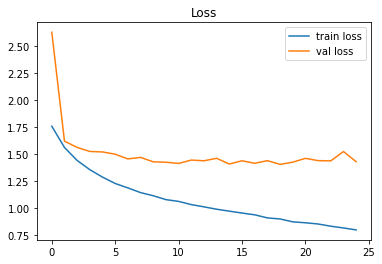

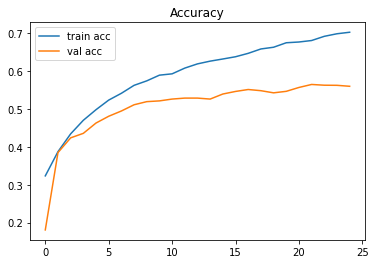

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
print(val_set.class_indices)
print(test_set.class_indices)

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}
{'angry': 0, 'fearful': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}


In [ ]:
cnn_auc = model.evaluate(test_set)

111/111 [==============================] - 3s 27ms/step - loss: 1.0022 - accuracy: 0.6383


# Testing

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

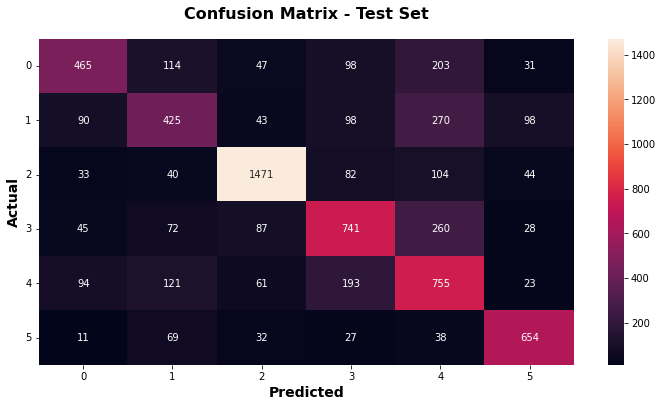

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
),
annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55       958
           1       0.51      0.42      0.46      1024
           2       0.84      0.83      0.84      1774
           3       0.60      0.60      0.60      1233
           4       0.46      0.61      0.52      1247
           5       0.74      0.79      0.77       831

    accuracy                           0.64      7067
   macro avg       0.63      0.62      0.62      7067
weighted avg       0.64      0.64      0.64      7067



# Predicting

In [ ]:
def predict(path):

    img = cv2.imread(path,)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48,48),interpolation=cv2.INTER_NEAREST)
    plt.axis('off')
    plt.imshow(img,cmap = 'gray')
    img = np.expand_dims(img,axis=0)
    predict = load_model.predict(img)
    predict = np.argmax(predict,axis = 1)

    if predict == 0:
      print('Angry')
    elif predict== 1:
      print('Fear')
    elif predict== 2:
      print('Happy')
    elif predict== 3:
      print('Nutral')
    elif predict== 4:
      print('Sad')
    elif predict== 5:
      print('Surprise')



Fear


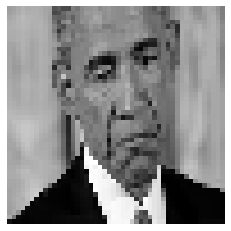

In [ ]:
predict('/content/sad2.jpg')

# GRAD - Cam

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

In [2]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [3]:
import pickle
load_model = pickle.load(open('/content/drive/MyDrive/Emotionmodel.pkl','rb'))

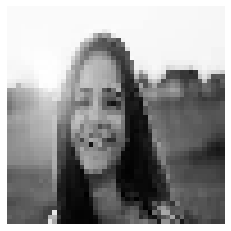

In [18]:
img = cv2.imread('/content/gtgtg.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (48,48),interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(img,cmap = 'gray')
img = np.expand_dims(img,axis=0)
predict = load_model.predict(img)
predict = np.argmax(predict,axis = 1)

In [19]:
predict[0]

2

In [20]:
for idx in range(len(load_model.layers)):
  print(load_model.get_layer(index = idx).name)

conv2d_40
batch_normalization_11
dropout_21
conv2d_41
batch_normalization_12
max_pooling2d_22
conv2d_42
batch_normalization_13
dropout_22
conv2d_43
batch_normalization_14
max_pooling2d_23
flatten_10
dense_30
batch_normalization_15
dropout_23
dense_31
dense_32


(48, 48) (48, 48, 3)


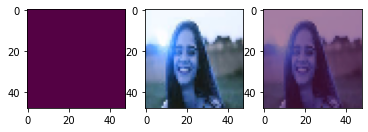

In [21]:
icam = GradCAM(load_model, predict[0], 'max_pooling2d_23') 
heatmap = icam.compute_heatmap(img)
heatmap = cv2.resize(heatmap, (48, 48))

image = cv2.imread('/content/gtgtg.jpg')
image = cv2.resize(image, (48, 48))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)